In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from pyrealm.pmodel import PModel, PModelEnvironment, SubdailyScaler, SubdailyPModel
from pyrealm.pmodel.functions import calc_ftemp_arrh, calc_ftemp_kphio
from pyrealm.pmodel.subdaily import memory_effect
from pyrealm.pmodel.optimal_chi import OptimalChiPrentice14
from sklearn.metrics import mean_squared_error, r2_score

def pModel_subdaily_area(
    datetime_subdaily: np.ndarray,
    temp_subdaily: np.ndarray,
    ppfd_subdaily: np.ndarray,
    vpd_subdaily: np.ndarray,
    co2_subdaily: np.ndarray,
    patm_subdaily: np.ndarray,
    fpar_subdaily: np.ndarray,
    days_memory: float,
    window_center_i: int,
    half_width_i: int,
):

    # Calculate the photosynthetic environment
    subdaily_env = PModelEnvironment(
        tc=temp_subdaily,
        vpd=vpd_subdaily,
        co2=co2_subdaily,
        patm=patm_subdaily,
    )

    # Create the fast slow scaler
    fsscaler = SubdailyScaler(datetime_subdaily)

    # Set the acclimation window as the values within a one hour window centred on noon
    fsscaler.set_window(
        window_center=np.timedelta64(window_center_i, "h"),
        half_width=np.timedelta64(half_width_i, "m"),
    )

    # Fit the P Model with fast and slow responses
    pmodel_subdaily = SubdailyPModel(
        env=subdaily_env,
        fs_scaler=fsscaler,
        allow_holdover=True,
        ppfd=ppfd_subdaily,
        fapar=fpar_subdaily,
    )

    temp_acclim = fsscaler.get_daily_means(temp_subdaily)
    co2_acclim = fsscaler.get_daily_means(co2_subdaily)
    vpd_acclim = fsscaler.get_daily_means(vpd_subdaily)
    patm_acclim = fsscaler.get_daily_means(patm_subdaily)
    ppfd_acclim = fsscaler.get_daily_means(ppfd_subdaily)
    fapar_acclim = fsscaler.get_daily_means(fpar_subdaily)

    # Fit the P Model to the acclimation conditions
    daily_acclim_env = PModelEnvironment(
        tc=temp_acclim, vpd=vpd_acclim, co2=co2_acclim, patm=patm_acclim
    )

    pmodel_acclim = PModel(daily_acclim_env, kphio=1 / 8)
    pmodel_acclim.estimate_productivity(fapar=fapar_acclim, ppfd=ppfd_acclim)
    # pmodel_acclim.summarize()

    ha_vcmax25 = 65330
    ha_jmax25 = 43900
    tk_acclim = temp_acclim + pmodel_subdaily.env.core_const.k_CtoK
    vcmax25_acclim = pmodel_acclim.vcmax * (1 / calc_ftemp_arrh(tk_acclim, ha_vcmax25))
    jmax25_acclim = pmodel_acclim.jmax * (1 / calc_ftemp_arrh(tk_acclim, ha_jmax25))
    # Calculation of memory effect in xi, vcmax25 and jmax25
    xi_real = memory_effect(
        pmodel_acclim.optchi.xi, alpha=1 / days_memory, allow_holdover=True
    )
    vcmax25_real = memory_effect(
        vcmax25_acclim, alpha=1 / days_memory, allow_holdover=True
    )
    jmax25_real = memory_effect(
        jmax25_acclim, alpha=1 / days_memory, allow_holdover=True
    )
    tk_subdaily = subdaily_env.tc + pmodel_subdaily.env.core_const.k_CtoK

    # Fill the realised jmax and vcmax from subdaily to daily
    vcmax25_subdaily = fsscaler.fill_daily_to_subdaily(vcmax25_real)
    jmax25_subdaily = fsscaler.fill_daily_to_subdaily(jmax25_real)

    # Adjust to actual temperature at subdaily timescale
    vcmax_subdaily = vcmax25_subdaily * calc_ftemp_arrh(tk=tk_subdaily, ha=ha_vcmax25)
    jmax_subdaily = jmax25_subdaily * calc_ftemp_arrh(tk=tk_subdaily, ha=ha_jmax25)

    # Interpolate xi to subdaily scale
    xi_subdaily = fsscaler.fill_daily_to_subdaily(xi_real)

    # Calculate the optimal chi, imposing the realised xi values
    subdaily_chi = OptimalChiPrentice14(env=subdaily_env)
    subdaily_chi.estimate_chi(xi_values=xi_subdaily)

    # Calculate Ac
    Ac_subdaily = (
        vcmax_subdaily
        * (subdaily_chi.ci - subdaily_env.gammastar)
        / (subdaily_chi.ci + subdaily_env.kmm)
    )

    # Calculate J and Aj
    phi = (1 / 8) * calc_ftemp_kphio(tc=temp_subdaily)
    iabs = fpar_subdaily * ppfd_subdaily

    J_subdaily = (4 * phi * iabs) / np.sqrt(1 + ((4 * phi * iabs) / jmax_subdaily) ** 2)

    Aj_subdaily = (
        (J_subdaily / 4)
        * (subdaily_chi.ci - subdaily_env.gammastar)
        / (subdaily_chi.ci + 2 * subdaily_env.gammastar)
    )

    # Calculate GPP and convert from micromols to micrograms
    GPP_subdaily = (
        np.minimum(Ac_subdaily, Aj_subdaily)
        * pmodel_subdaily.env.core_const.k_c_molmass
    )

    gC_to_mumol = 0.0833  # 1 µg C m⁻² s⁻¹ × (1 µmol C / 12.01 µg C) × (1 µmol CO₂ / 1 µmol C) = 0.0833 µmol CO₂ m⁻² s⁻¹
    GPP_subdaily *= gC_to_mumol
    # print(
    #     f"GPPmean {np.nanmean(GPP_subdaily)} at {days_memory} days_mem at {window_center_i}h {half_width_i}m"
    # )

    return GPP_subdaily



In [28]:

# remember to change the path of your file

start_year = 1999
end_year = 2013

datetime_subdaily=np.arange(datetime(start_year, 1, 1, 0, 00),
              datetime(end_year,1,1,0,0),
              np.timedelta64(30, "m"))

# site_file = "/scratch/c7071034/DATA/Fluxnet2015/Alps/FLX_CH-Lae_FLUXNET2015_FULLSET_2004-2014_1-4/FLX_CH-Lae_FLUXNET2015_FULLSET_HH_2004-2014_1-4.csv"
site_file = "/scratch/c7071034/DATA/Fluxnet2015/Alps/FLX_IT-Ren_FLUXNET2015_FULLSET_1998-2013_1-4/FLX_IT-Ren_FLUXNET2015_FULLSET_HH_1998-2013_1-4.csv"
# site_file = "/scratch/c7071034/DATA/Fluxnet2015/Alps/FLX_CH-Dav_FLUXNET2015_FULLSET_1997-2014_1-4/FLX_CH-Dav_FLUXNET2015_FULLSET_HH_1997-2014_1-4.csv"

ds = pd.read_csv(site_file)
# extract site name from the file name CH-Dav
site_name = site_file.split("/")[-1].split("_")[1]


# filter ds by ds["TIMESTAMP_START"] with format YYYMMDDHHSS to start_year till 1.1. 00:00h of end_year
ds["TIMESTAMP_START"] = pd.to_datetime(ds["TIMESTAMP_START"], format='%Y%m%d%H%M')
ds = ds[(ds["TIMESTAMP_START"] >= datetime(start_year, 1, 1, 0, 00)) & (ds["TIMESTAMP_START"] < datetime(end_year, 1, 1, 0, 00))]
ds = ds.set_index("TIMESTAMP_START")

# Extract the key half hourly timestep variables as numpy arrays
site_temp = ds.loc[:, 'TA_F_MDS'] # daily temperature, unit degree (°C)
site_temp[site_temp < -25] = np.nan
site_swin = ds.loc[:, 'SW_IN_F_MDS']  # shortwave radiation, unit W/m2
site_ppfd = ds.loc[:, 'PPFD_IN'] # Shortwave radiation (W/m²) × 0.50 -> PAR (W/m²) × 4.6 -> PPFD (umol/m²/s)
site_vpd = ds.loc[:, 'VPD_F_MDS'] * 100  # vpd, unit: hPa converted to Pa
site_co2 = ds.loc[:, 'CO2_F_MDS']  # CO2, unit ppm
site_patm = ds.loc[:, 'PA_F'] * 1000  # site pressure, unit kPa converted to Pa
site_prep = ds.loc[:,'P_F']
site_gpp = ds.loc[:,'GPP_DT_VUT_USTAR50']  # GPP, unit: gC/m2/d


#site_fapar = ds.loc[:, 'FPAR']  # fapar
#ds.columns
#site_ppfd = ds.loc[:, 'PPFD_IN'] 
site_ppfd.max()
mod_files =  "/scratch/c7071034/DATA/Fluxnet2015/Alps/FLX_IT-Ren_FLUXNET2015_FULLSET_1998-2013_1-4/IT-Ren_MOD15A2H_Fpar_500m_1997-12-12_2014-01-20.xlsx" 
myd_files = "/scratch/c7071034/DATA/Fluxnet2015/Alps/FLX_IT-Ren_FLUXNET2015_FULLSET_1998-2013_1-4/IT-Ren_MYD15A2H_Fpar_500m_1997-12-12_2014-01-20.xlsx"

# Process MOD and MYD files
dfs_modis = []
for file_path in [mod_files, myd_files]:
    df = pd.read_excel(file_path)[["calendar_date", "value"]].assign(
        value=lambda x: x["value"] * 0.0001  # TODO: scale Lai diffently
    )  # sclaing factor from user guide: https://lpdaac.usgs.gov/documents/103/MOD13_User_Guide_V6.pdf
    file_parts = file_path.split("/")[-1]
    file_parts2 = file_parts.split("_")[2:6]
    if file_parts2[0] == "250m":
        file_type = "_".join(file_parts2)
    else:
        file_type = "_".join(file_parts2[:-1])
    df.rename(columns={"value": file_type}, inplace=True)
    dfs_modis.append(df)

# Merge dataframes based on 'calendar_date'
df_modis = dfs_modis[0]
for df in dfs_modis[1:]:
    df_modis = pd.merge(
        df_modis, df, on="calendar_date", how="outer", suffixes=("_x", "_y")
    )

for column in df_modis.columns:
    if column.endswith("_x"):
        base_column = column[:-2]  # Remove suffix '_x'
        if base_column + "_y" in df_modis.columns:
            df_modis[column].fillna(df_modis[base_column + "_y"], inplace=True)
            df_modis.drop(columns=[base_column + "_y"], inplace=True)
            df_modis.rename(columns={column: base_column}, inplace=True)

df_modis.sort_values(by="calendar_date", inplace=True)
df_modis.reset_index(drop=True, inplace=True)
df_modis["calendar_date"] = pd.to_datetime(df_modis["calendar_date"])
df_modis.set_index("calendar_date", inplace=True)
# Interpolation
subdaily_series = pd.Series(index=datetime_subdaily, dtype=float)

# Reindex with interpolation
site_fapar = df_modis["Fpar_500m_1997-12-12"].reindex(
    subdaily_series.index.union(df_modis.index)
).interpolate("time").reindex(subdaily_series.index)
site_fapar = site_fapar*100 # 100 due to MODIS scaling factor, and 100 to convert to percent
#clip to zero 
site_vpd.values[site_vpd.values < 0] = 0
site_ppfd.values[site_ppfd.values < 0] = 0
# site_fapar.max()

pyrealm/2272759546.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
pyrealm/2272759546.py:69: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.




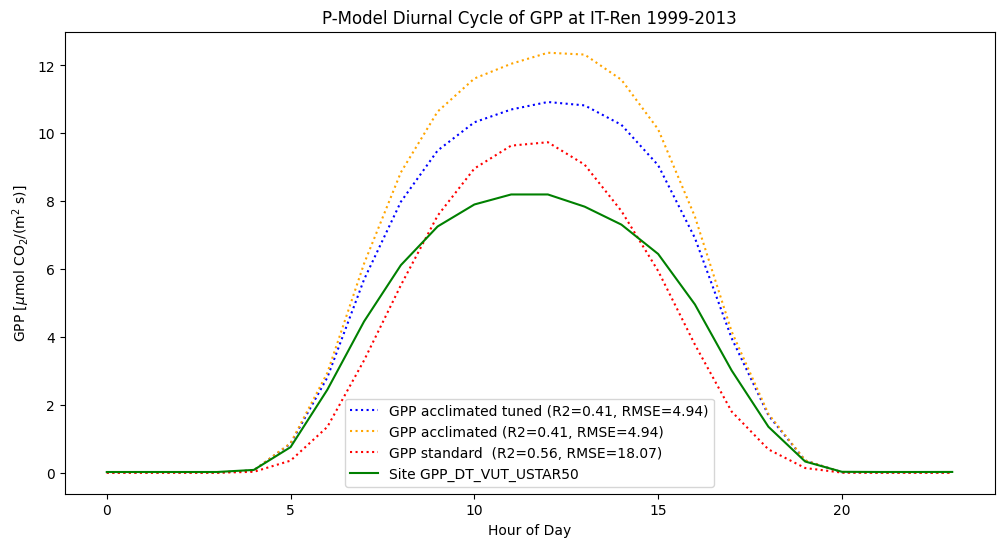

np.float64(0.7506150105290728)

In [29]:
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

gC_to_mumol =  0.0833  # 1 µg C m⁻² s⁻¹ × (1 µmol C / 12.01 µg C) × (1 µmol CO₂ / 1 µmol C) = 0.0833 µmol CO₂ m⁻² s⁻¹

env = PModelEnvironment(tc=site_temp.values, co2=site_co2.values, patm=site_patm.values, vpd=site_vpd.values)
model = PModel(
    env
)  # TODO try: model = PModel(env, method_kphio="fixed", reference_kphio=1 / 8)
model.estimate_productivity(site_fapar.values, site_ppfd.values)
pmodel_subdaily_std = model.gpp*gC_to_mumol

# Is identical to code below
# Calculate the photosynthetic environment
subdaily_env = PModelEnvironment(
    tc=site_temp.values,
    vpd=site_vpd.values,
    co2=site_co2.values,
    patm=site_patm.values,
)
# Create the fast slow scaler
fsscaler = SubdailyScaler(datetime_subdaily)
# Set the acclimation window as the values within a one hour window centred on noon
fsscaler.set_window(
    window_center=np.timedelta64(12, "h"),
    half_width=np.timedelta64(30, "m"),
)

# Fit the P Model with fast and slow responses
days_mem = 15 
pmodel_subdaily = SubdailyPModel(
    env=subdaily_env,
    fs_scaler=fsscaler,
    allow_holdover=True,
    ppfd=site_ppfd.values,
    fapar=site_fapar.values,
    alpha=1/days_mem
)
pmodel_subdaily_acc = pmodel_subdaily.gpp*gC_to_mumol

# # IT-Ren
# days_mem = 22
# window_cent = 14
# half_wdth = 28
# Average 
days_mem = 37
window_cent = 13
half_wdth = 90

pmodel_subdaily_acc_tune = pModel_subdaily_area(
        datetime_subdaily,
        site_temp.values,
        site_ppfd.values,
        site_vpd.values,
        site_co2.values,
        site_patm.values,
        site_fapar.values,
        days_mem,
        window_cent,
        half_wdth,
    )


# Create a DataFrame with the datetime index and the GPP values
df_gpp = pd.DataFrame({
    'datetime': datetime_subdaily,
    'pmodel_subdaily_acc_tune': pmodel_subdaily_acc_tune,
    'pmodel_subdaily_acc': pmodel_subdaily_acc,
    'model_gpp_std': pmodel_subdaily_std,
    'site_gpp': site_gpp.values
})

# Extract the hour from the datetime index
df_gpp['hour'] = df_gpp['datetime'].dt.hour

# Calculate the hourly averages
hourly_avg_acc_tune = df_gpp.groupby('hour')['pmodel_subdaily_acc_tune'].mean()
hourly_avg_model_acc = df_gpp.groupby('hour')['pmodel_subdaily_acc'].mean()
hourly_avg_model_std = df_gpp.groupby('hour')['model_gpp_std'].mean()
hourly_avg_site = df_gpp.groupby('hour')['site_gpp'].mean()

# Clean data from NaN values
df_gpp_clean = df_gpp.dropna(subset=['pmodel_subdaily_acc_tune', 'model_gpp_std', 'site_gpp'])

# Calculate R2 and RMSE for pmodel_subdaily_acc_tune
r2_slow_fast = r2_score(df_gpp_clean['site_gpp'], df_gpp_clean['pmodel_subdaily_acc_tune'])
rmse_slow_fast = sqrt(mean_squared_error(df_gpp_clean['site_gpp'], df_gpp_clean['pmodel_subdaily_acc_tune']))
# Calculate R2 and RMSE for pmodel_subdaily_acc
r2_slow_fast = r2_score(df_gpp_clean['site_gpp'], df_gpp_clean['pmodel_subdaily_acc'])
rmse_slow_fast = sqrt(mean_squared_error(df_gpp_clean['site_gpp'], df_gpp_clean['pmodel_subdaily_acc']))
# Calculate R2 and RMSE for model_gpp_std
r2_err = r2_score(df_gpp_clean['site_gpp'], df_gpp_clean['model_gpp_std'])
rmse_err = mean_squared_error(df_gpp_clean['site_gpp'], df_gpp_clean['model_gpp_std'])

# Plot the diurnal cycles
plt.figure(figsize=(12, 6))

plt.plot(hourly_avg_acc_tune.index, hourly_avg_acc_tune, label=f'GPP acclimated tuned (R2={r2_slow_fast:.2f}, RMSE={rmse_slow_fast:.2f})', color='blue',linestyle='dotted')
plt.plot(hourly_avg_model_acc.index, hourly_avg_model_acc, label=f'GPP acclimated (R2={r2_slow_fast:.2f}, RMSE={rmse_slow_fast:.2f})', color='orange',linestyle='dotted')
plt.plot(hourly_avg_model_std.index, hourly_avg_model_std, label=f'GPP standard  (R2={r2_err:.2f}, RMSE={rmse_err:.2f})', color='red',linestyle='dotted')
plt.plot(hourly_avg_site.index, hourly_avg_site, label='Site GPP_DT_VUT_USTAR50', color='green')

plt.title(f'P-Model Diurnal Cycle of GPP at {site_name} {start_year}-{end_year}')
plt.xlabel('Hour of Day')
plt.ylabel(r'GPP [$\mu$mol CO$_2$/(m$^2$ s)]')
plt.legend()
plt.show()


hourly_avg_site.max()/hourly_avg_acc_tune.max()
